# 🔬 Fingerprint-Based Blood Group Classification

## 📌 Objective
To classify human blood groups based on fingerprint images using deep learning models like CNN, ViT, and BeiT.

## 📂 Dataset
The dataset used is from Kaggle: [Fingerprint Blood Group Dataset](https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset).

## 🧠 Models Used
- CNN (ResNet-18)
- ViT (Vision Transformer - `vit_base_patch16_224`)
- BeiT (`beit_base_patch16_224`)

All models were implemented using PyTorch and `timm`.

## ⚙️ Training Details
- Batch Size: 64
- Loss: Label Smoothing Cross Entropy
- Optimizer: Adam
- Scheduler: ReduceLROnPlateau
- Techniques: Early Stopping, Dropout, Data Augmentation

## 📊 Evaluation Metrics
- Accuracy
- Confusion Matrix
- Training/Validation Accuracy and Loss Curves

## ✅ Conclusion
ViT performed the best with an accuracy of 90.83%. Further tuning may improve CNN and BeiT performances.

---

In [1]:
# STEP 1: IMPORTS AND DEVICE CONFIGURATION
import os
import zipfile
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set deterministic behavior for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# DEVICE SETUP
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# STEP 2: DATA LOADING AND PREPROCESSING
zip_path = "/content/archive (9).zip"
dataset_path = "/content/dataset/dataset_blood_group"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [5]:
# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

In [6]:
# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [7]:
# Use larger batch size for speedup
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [8]:
# STEP 3: MODELS
from torchvision.models import resnet18

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

class BeiTModel(nn.Module):
    def __init__(self, num_classes):
        super(BeiTModel, self).__init__()
        self.model = timm.create_model("beit_base_patch16_224", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [9]:
# STEP 4: LOSS FUNCTION
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))


In [10]:
# STEP 5: TRAINING FUNCTION
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

def train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=10, patience=2):
    best_acc, trigger = 0, 0
    criterion = LabelSmoothingLoss(classes=num_classes)
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping triggered!")
                break

    return best_acc

In [11]:
# STEP 6: TRAIN AND EVALUATE
models = {
    "CNN": CNNModel(num_classes).to(DEVICE),
    "ViT": ViTModel(num_classes).to(DEVICE),
    "BeiT": BeiTModel(num_classes).to(DEVICE)
}

optimizers = {
    name: optim.Adam(model.parameters(), lr=0.0003 if name == "CNN" else 0.0001)
    for name, model in models.items()
}

schedulers = {
    name: optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
    for name, optimizer in optimizers.items()
}

results = {}
for name in models:
    print(f"\nTraining {name}...")
    acc = train(models[name], optimizers[name], schedulers[name], train_loader, val_loader)
    test_acc = evaluate(models[name], test_loader)
    results[name] = test_acc
    print(f"✅ {name} Test Accuracy: {test_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]


Training CNN...
Epoch 1/10 - Loss: 1.3315, Train Acc: 59.04%, Val Acc: 80.50%
Epoch 2/10 - Loss: 0.9684, Train Acc: 79.58%, Val Acc: 79.50%
Epoch 3/10 - Loss: 0.9120, Train Acc: 82.12%, Val Acc: 83.67%
Epoch 4/10 - Loss: 0.8690, Train Acc: 84.40%, Val Acc: 87.33%
Epoch 5/10 - Loss: 0.8512, Train Acc: 85.08%, Val Acc: 86.33%
Epoch 6/10 - Loss: 0.8157, Train Acc: 87.27%, Val Acc: 86.83%
Early stopping triggered!
✅ CNN Test Accuracy: 87.17%

Training ViT...
Epoch 1/10 - Loss: 1.6638, Train Acc: 37.88%, Val Acc: 66.33%
Epoch 2/10 - Loss: 0.9621, Train Acc: 78.44%, Val Acc: 84.67%
Epoch 3/10 - Loss: 0.8300, Train Acc: 84.94%, Val Acc: 86.00%
Epoch 4/10 - Loss: 0.7836, Train Acc: 86.67%, Val Acc: 87.33%
Epoch 5/10 - Loss: 0.7705, Train Acc: 87.85%, Val Acc: 85.67%
Epoch 6/10 - Loss: 0.7517, Train Acc: 88.50%, Val Acc: 89.50%
Epoch 7/10 - Loss: 0.7273, Train Acc: 89.73%, Val Acc: 91.00%
Epoch 8/10 - Loss: 0.7160, Train Acc: 90.35%, Val Acc: 90.83%
Epoch 9/10 - Loss: 0.6807, Train Acc: 92.71%


📊 Classification Report for CNN
              precision    recall  f1-score   support

          A+       0.88      0.88      0.88        51
          A-       0.85      0.95      0.90        97
         AB+       0.97      0.80      0.88        76
         AB-       0.94      0.83      0.88        70
          B+       0.95      0.91      0.93        77
          B-       0.85      0.99      0.92        71
          O+       0.84      0.89      0.86        80
          O-       0.88      0.85      0.86        78

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



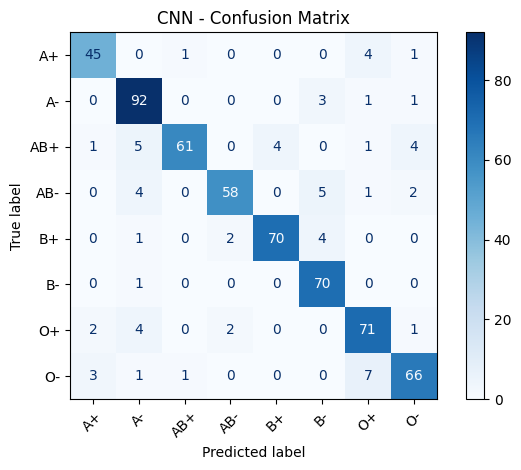


📊 Classification Report for ViT
              precision    recall  f1-score   support

          A+       0.95      0.76      0.85        51
          A-       0.87      0.92      0.89        97
         AB+       0.91      0.96      0.94        76
         AB-       0.86      0.89      0.87        70
          B+       0.92      0.84      0.88        77
          B-       1.00      0.90      0.95        71
          O+       0.88      0.88      0.88        80
          O-       0.83      0.96      0.89        78

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.90      0.89       600



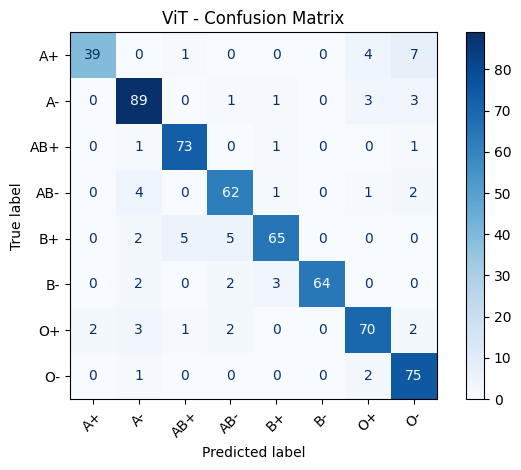


📊 Classification Report for BeiT
              precision    recall  f1-score   support

          A+       0.83      0.96      0.89        51
          A-       0.91      0.81      0.86        97
         AB+       0.91      0.93      0.92        76
         AB-       0.81      0.87      0.84        70
          B+       0.94      0.79      0.86        77
          B-       0.85      0.96      0.90        71
          O+       0.82      0.81      0.82        80
          O-       0.86      0.85      0.85        78

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



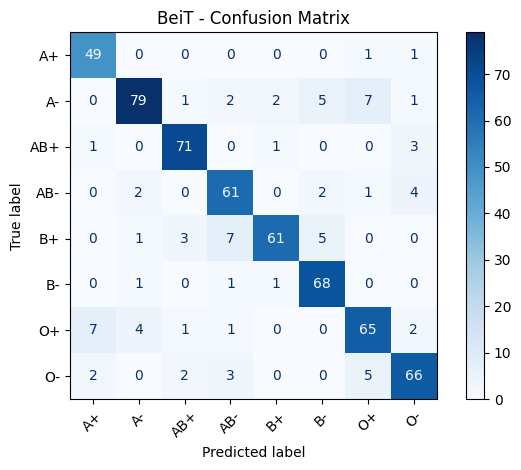

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_metrics(model, loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(f"\n📊 Classification Report for {model_name}")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=2))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Evaluate each model
for name, model in models.items():
    evaluate_metrics(model, test_loader, name)


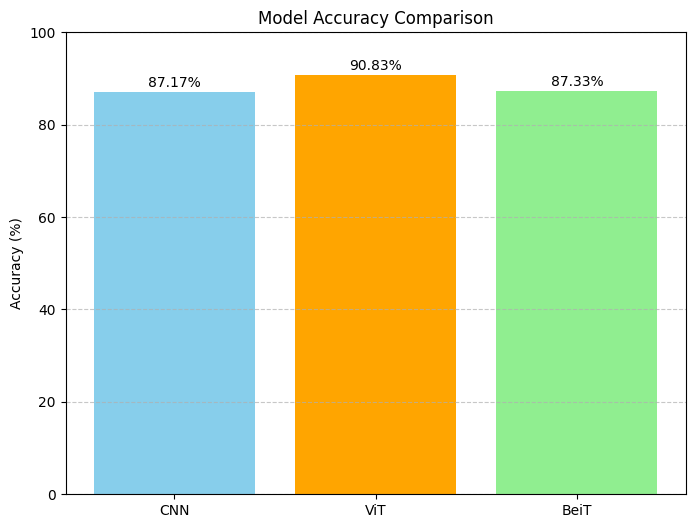

In [12]:
# STEP 7: VISUALIZATION
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'lightgreen'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for k, v in results.items():
    plt.text(k, v + 1, f"{v:.2f}%", ha='center')
plt.show()


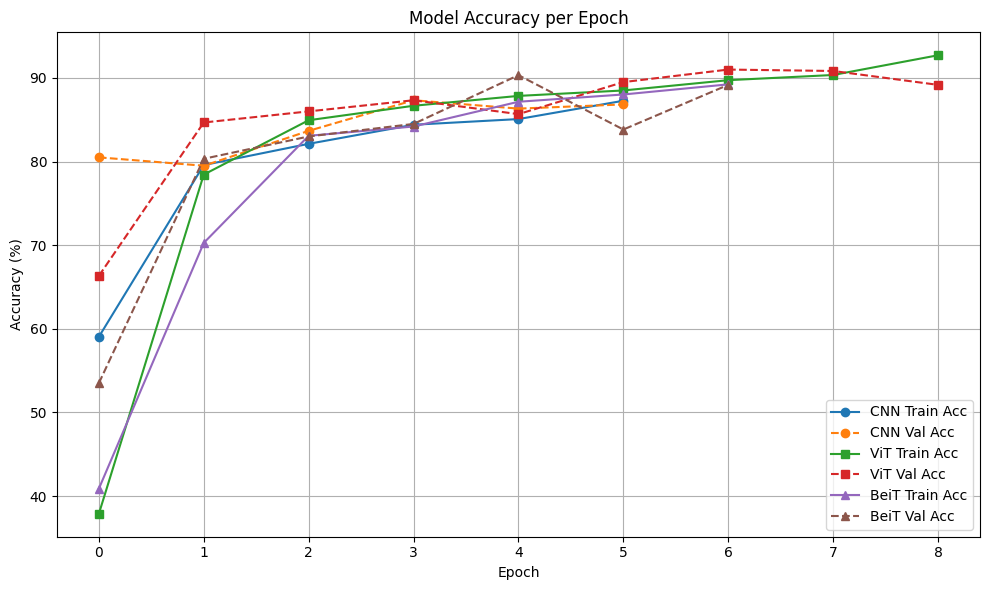

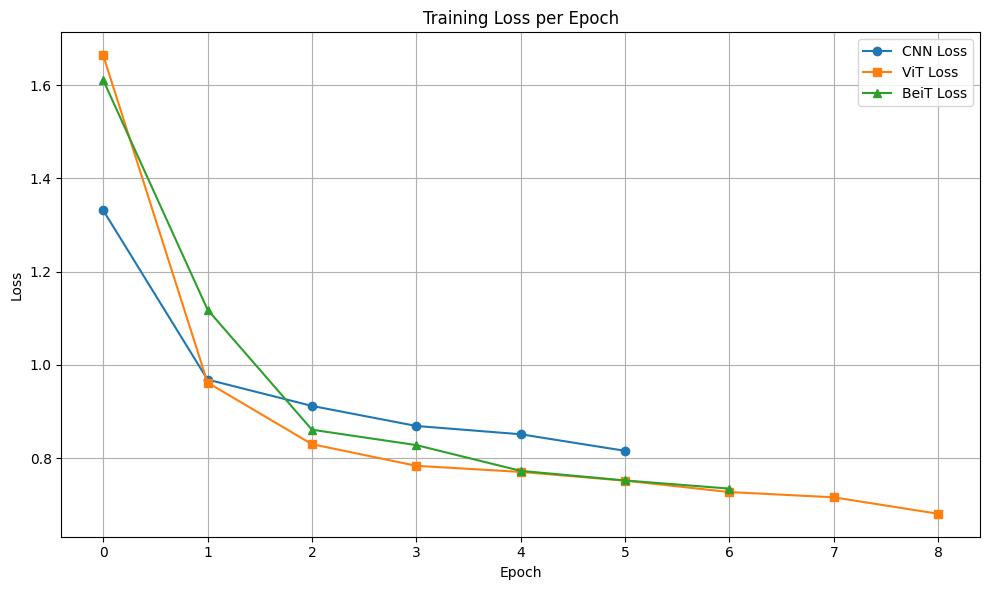

In [14]:
import matplotlib.pyplot as plt

# Manually filled values from your output
epochs = list(range(1, 8))

cnn_train_acc = [59.04, 79.58, 82.12, 84.40, 85.08, 87.27]
cnn_val_acc = [80.50, 79.50, 83.67, 87.33, 86.33, 86.83]
cnn_loss = [1.3315, 0.9684, 0.9120, 0.8690, 0.8512, 0.8157]

vit_train_acc = [37.88, 78.44, 84.94, 86.67, 87.85, 88.50, 89.73, 90.35, 92.71]
vit_val_acc = [66.33, 84.67, 86.00, 87.33, 85.67, 89.50, 91.00, 90.83, 89.17]
vit_loss = [1.6638, 0.9621, 0.8300, 0.7836, 0.7705, 0.7517, 0.7273, 0.7160, 0.6807]

beit_train_acc = [40.88, 70.27, 83.08, 84.19, 87.15, 88.02, 89.23]
beit_val_acc = [53.50, 80.33, 83.00, 84.50, 90.33, 83.83, 89.17]
beit_loss = [1.6109, 1.1184, 0.8610, 0.8280, 0.7728, 0.7522, 0.7347]

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(cnn_train_acc, label='CNN Train Acc', marker='o', linestyle='-')
plt.plot(cnn_val_acc, label='CNN Val Acc', marker='o', linestyle='--')
plt.plot(vit_train_acc, label='ViT Train Acc', marker='s', linestyle='-')
plt.plot(vit_val_acc, label='ViT Val Acc', marker='s', linestyle='--')
plt.plot(beit_train_acc, label='BeiT Train Acc', marker='^', linestyle='-')
plt.plot(beit_val_acc, label='BeiT Val Acc', marker='^', linestyle='--')
plt.title("Model Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(cnn_loss, label='CNN Loss', marker='o')
plt.plot(vit_loss, label='ViT Loss', marker='s')
plt.plot(beit_loss, label='BeiT Loss', marker='^')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
